In [3]:
import os
import glob
from keras.preprocessing.image import ImageDataGenerator,array_to_img, img_to_array, load_img
import shutil
import PIL
from keras.models import Model, load_model

In [4]:
!pwd

/media/hdd1/dataset/celebrityfaces


### Training from scratch, we will avoid this for celebrity faces

In [5]:
#Build a Keras Graph
from keras.models import Sequential
from keras.layers import Conv2D, MaxPooling2D
from keras.layers  import Dense, Dropout, Activation, Flatten
from keras.layers import Conv2D, MaxPooling2D
from keras.preprocessing.image import ImageDataGenerator

In [10]:
from keras.utils import multi_gpu_model
import keras

model = Sequential()
#First conv output of 32 layer 3,3 matrix
model.add(Conv2D(64,(3,3), input_shape=(299,299,3), padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))
# Second Conv Layes
model.add(Conv2D(128,(3,3),padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))

model.add(Conv2D(256,(3,3),padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Conv2D(512,(3,3),padding="same" ))
model.add(Activation("relu"))
model.add(MaxPooling2D(pool_size=(2,2)))


model.add(Flatten())
model.add(Dense(1024))
model.add(Activation("elu"))
model.add(Dropout(0.3))
model.add(Dense(512))
model.add(Activation("elu"))
model.add(Dropout(0.3))
model.add(Dense(8))
model.add(Activation("softmax"))
opt = keras.optimizers.Adagrad(lr=0.001)
#parallel_model = multi_gpu_model(model, gpus=)
model.compile(loss='categorical_crossentropy', optimizer=opt, metrics=["accuracy"])

In [11]:
model.summary()

_________________________________________________________________
Layer (type)                 Output Shape              Param #   
conv2d_9 (Conv2D)            (None, 299, 299, 64)      1792      
_________________________________________________________________
activation_15 (Activation)   (None, 299, 299, 64)      0         
_________________________________________________________________
max_pooling2d_9 (MaxPooling2 (None, 149, 149, 64)      0         
_________________________________________________________________
conv2d_10 (Conv2D)           (None, 149, 149, 128)     73856     
_________________________________________________________________
activation_16 (Activation)   (None, 149, 149, 128)     0         
_________________________________________________________________
max_pooling2d_10 (MaxPooling (None, 74, 74, 128)       0         
_________________________________________________________________
conv2d_11 (Conv2D)           (None, 74, 74, 256)       295168    
__________

In [12]:
!ls -ltr train|wc -l

991


### This is for the image generator

In [13]:
batch_size = 10
train_datagen =  ImageDataGenerator(rescale=1./255, shear_range=0.2, zoom_range=0.2,horizontal_flip=True)
test_datagen = ImageDataGenerator(rescale=1./255)

In [20]:
train_generator = train_datagen.flow_from_directory('tmp_train',target_size=(299,299), batch_size=batch_size, class_mode="categorical")



Found 6054 images belonging to 8 classes.


In [21]:
class_indices = train_generator.class_indices

In [22]:
validation_generator = test_datagen.flow_from_directory(
        'tmp_test',
        target_size=(299, 299),
        batch_size=batch_size,
        class_mode='categorical')

Found 67 images belonging to 8 classes.


In [23]:
val_class_indices = validation_generator.class_indices

In [24]:
set(val_class_indices) - set(class_indices)

set()

### Skip this for now as we are testing transfer learning

In [ ]:
import keras
#TBlogger = keras.callbacks.ModelCheckpoint("./logs", monitor='val_loss', verbose=0, save_best_only=False, save_weights_only=False, mode='auto', period=1)
early_stopping = keras.callbacks.EarlyStopping(monitor='val_acc', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
history = model.fit_generator(train_generator, steps_per_epoch=2500, epochs=100, validation_data=validation_generator, validation_steps=800, callbacks=[early_stopping])



Epoch 1/100
2499/2500 [============================>.] - ETA: 0s - loss: 1.6502 - acc: 0.3989

In [16]:
#model.save("cat_dog_modelgood.h5")

In [17]:
!ls -ltr models

total 1207848
-rw-rw-r-- 1 sdutta sdutta 1236831280 Jun 13 11:40 Densenet_7Celeb.h5


In [18]:
def convert_image_to_bgr_numpy_array(image_path, size=[224,224]):
    """The network has been trained using opencv and BGR images 
    (i.e. channels order blue, green, red rather than red, green, blue).
    The description of why is https://stackoverflow.com/questions/14556545/why-opencv-using-bgr-colour-space-instead-of-rgb
    
    We can use a simpler image library as long as we manually convert
    the data to the expected format.
    """
    image = PIL.Image.open(image_path).resize((size),PIL.Image.ADAPTIVE)
    img_data = np.array(image.getdata(), np.float32).reshape(224,224, -1)
    # swap R and B channels
    img_data = np.flip(img_data, axis=2)
    return img_data

def prepare_image(image_path):
    im = convert_image_to_bgr_numpy_array(image_path)

    # these subtractions are just mean centering the images 
    # based on known means for different color channels
    im[:,:,0] -= 103.939
    im[:,:,1] -= 116.779
    im[:,:,2] -= 123.68

    im = im.transpose((2,0,1)) # adjust from (224, 224, 3) to (3, 224, 224) for keras
    im = np.expand_dims(im, axis=0) # adjust to (1, 3, 224, 224) for generating keras prediction
    return im

### Transfer Learning using InceptionV3
- Faster learning rate

In [19]:
from keras.models import Model
from keras.applications.vgg16 import VGG16
import keras
from keras.utils import multi_gpu_model
# note we exclude the final dense layers and add one back below, we would retrain it ourselves
#base_model = VGG16(weights='imagenet', include_top=False, input_shape=(224,224,3)) 
inception_model = keras.applications.DenseNet201(weights='imagenet',
                               include_top=False,
                               pooling=None,
                               input_shape=(224, 224, 3))


inception_model.summary()


__________________________________________________________________________________________________
Layer (type)                    Output Shape         Param #     Connected to                     
input_1 (InputLayer)            (None, 224, 224, 3)  0                                            
__________________________________________________________________________________________________
zero_padding2d_1 (ZeroPadding2D (None, 230, 230, 3)  0           input_1[0][0]                    
__________________________________________________________________________________________________
conv1/conv (Conv2D)             (None, 112, 112, 64) 9408        zero_padding2d_1[0][0]           
__________________________________________________________________________________________________
conv1/bn (BatchNormalization)   (None, 112, 112, 64) 256         conv1/conv[0][0]                 
__________________________________________________________________________________________________
conv1/relu

conv5_block29_concat (Concatena (None, 7, 7, 1824)   0           conv5_block28_concat[0][0]       
                                                                 conv5_block29_2_conv[0][0]       
__________________________________________________________________________________________________
conv5_block30_0_bn (BatchNormal (None, 7, 7, 1824)   7296        conv5_block29_concat[0][0]       
__________________________________________________________________________________________________
conv5_block30_0_relu (Activatio (None, 7, 7, 1824)   0           conv5_block30_0_bn[0][0]         
__________________________________________________________________________________________________
conv5_block30_1_conv (Conv2D)   (None, 7, 7, 128)    233472      conv5_block30_0_relu[0][0]       
__________________________________________________________________________________________________
conv5_block30_1_bn (BatchNormal (None, 7, 7, 128)    512         conv5_block30_1_conv[0][0]       
__________

In [20]:

# Freeze convolutional layers
for layer in inception_model.layers:
    #print layer
    layer.trainable = False    
    


In [21]:
transfer_model = Sequential()
transfer_model.add(inception_model)
transfer_model.add(Flatten())
transfer_model.add(Dense(1024, activation="elu"))
transfer_model.add(Dropout(0.3))
transfer_model.add(Dense(512, activation="elu"))
transfer_model.add(Dropout(0.5))
transfer_model.add(Dense(8, activation="softmax"))
#parallel_model = multi_gpu_model(transfer_model, gpus=4)
transfer_model.compile(loss='categorical_crossentropy', optimizer=keras.optimizers.adam(lr=1e-4), metrics=["accuracy"])

In [22]:
#train_generator = train_datagen.flow_from_directory('/media/hdd1/dataset/celebrityfaces/celebrityfacesdataset/train',target_size=(224,224), batch_size=10, class_mode="categorical")


In [24]:
early_stopping = keras.callbacks.EarlyStopping(monitor='acc', min_delta=0, patience=5, verbose=0, mode='auto', baseline=None, restore_best_weights=False)
transfer_history = transfer_model.fit_generator(train_generator, steps_per_epoch=600, epochs=50, validation_data=validation_generator, validation_steps=10, callbacks=[early_stopping])


Epoch 1/50
600/600 [==============================] - 137s 228ms/step - loss: 0.4680 - acc: 0.8481 - val_loss: 1.9546 - val_acc: 0.6082
Epoch 2/50
600/600 [==============================] - 138s 231ms/step - loss: 0.4952 - acc: 0.8408 - val_loss: 2.2105 - val_acc: 0.5106
Epoch 3/50
600/600 [==============================] - 138s 231ms/step - loss: 0.4286 - acc: 0.8570 - val_loss: 1.7631 - val_acc: 0.6186
Epoch 4/50
600/600 [==============================] - 139s 232ms/step - loss: 0.4092 - acc: 0.8664 - val_loss: 2.3208 - val_acc: 0.6170
Epoch 5/50
600/600 [==============================] - 142s 237ms/step - loss: 0.4175 - acc: 0.8618 - val_loss: 2.7318 - val_acc: 0.4227
Epoch 6/50
600/600 [==============================] - 139s 231ms/step - loss: 0.3891 - acc: 0.8697 - val_loss: 2.4097 - val_acc: 0.5638
Epoch 7/50
600/600 [==============================] - 140s 233ms/step - loss: 0.3847 - acc: 0.8733 - val_loss: 2.4154 - val_acc: 0.5052
Epoch 8/50
600/600 [============================

In [25]:
if (os.path.isdir("models") == False):
    os.mkdir("models")
transfer_model.save("models/Densenet_8Celebv2.h5")

In [26]:
from keras.utils.vis_utils import plot_model
plot_model(transfer_model, to_file='dense_8celeb.png')

In [4]:
new_mode=load_model("models/Densenet_8Celebv2.h5")

Instructions for updating:
Colocations handled automatically by placer.
Instructions for updating:
Please use `rate` instead of `keep_prob`. Rate should be set to `rate = 1 - keep_prob`.
Instructions for updating:
Use tf.cast instead.


In [6]:
import matplotlib.pyplot as plt

%matplotlib inline
def plot_history(history):
    train_history = history
    acc = train_history.history['acc']
    val_acc = train_history.history['val_acc']
    loss = train_history.history['loss']
    val_loss = train_history.history['val_loss']
    epochs = range(1, len(acc) + 1)
    plt.figure(figsize=(10,12))
    plt.plot(epochs, acc, 'blue', label='Training acc')
    plt.plot(epochs, val_acc, 'red', label='Validation acc')
    plt.title('Training and validation accuracy')
    plt.legend()
    #plt.figure()
    plt.figure(figsize=(10,12))
    plt.plot(epochs, loss, 'blue', label='Training loss')
    plt.plot(epochs, val_loss, 'red', label='Validation loss')
    plt.title('Training and validation loss')
    plt.legend()
    #plt.show()

#plt.subplot(2, 1, 1)    
#plot_history(history)
#plt.subplot(2, 1, 2)
plot_history(transfer_history)

NameError: name 'transfer_history' is not defined

In [29]:
test_gen = ImageDataGenerator(rescale=1./255)


In [14]:
indices_class = dict (zip(class_indices.values(),class_indices.keys()))

In [20]:
from keras.preprocessing import image
import numpy as np
def predict(fname):
    img = load_img(fname, target_size=(224,224))
    file = img_to_array(img)*1.0/255
    x = image.img_to_array(img)
    x = x*1.0/255
    x = np.expand_dims(x, axis=0)
    classes = new_mode.predict(x)
    arg_pred = np.argmax(classes)
    pred_label = indices_class.get(arg_pred)
    ranks = np.argsort(classes)
    print classes 
    print pred_label, classes[0][arg_pred], indices_class.get(ranks[0][-2])
    return classes, pred_label, indices_class.get(ranks[0][-2])
    '''
    if classes > 0.5:
        return "dog", classes
    else:
        return "cat", classes'''

In [15]:
class_indices,indices_class
#indices_class = dict (zip(class_indices.values(),class_indices.keys()))

({'Charlize Theron': 0,
  'Colin Farrell': 1,
  'Jennifer Lawrence': 2,
  'Jessica Alba': 3,
  'Mark Wahlberg': 4,
  'Robert De Niro': 5,
  'Unknown': 6,
  'Will Smith': 7},
 {0: 'Charlize Theron',
  1: 'Colin Farrell',
  2: 'Jennifer Lawrence',
  3: 'Jessica Alba',
  4: 'Mark Wahlberg',
  5: 'Robert De Niro',
  6: 'Unknown',
  7: 'Will Smith'})

[[9.1303524e-04 9.3452752e-02 1.8569331e-04 1.8535805e-03 4.7403148e-01
  2.4314038e-02 5.5529323e-04 4.0469417e-01]]
Mark Wahlberg 0.47403148 Will Smith


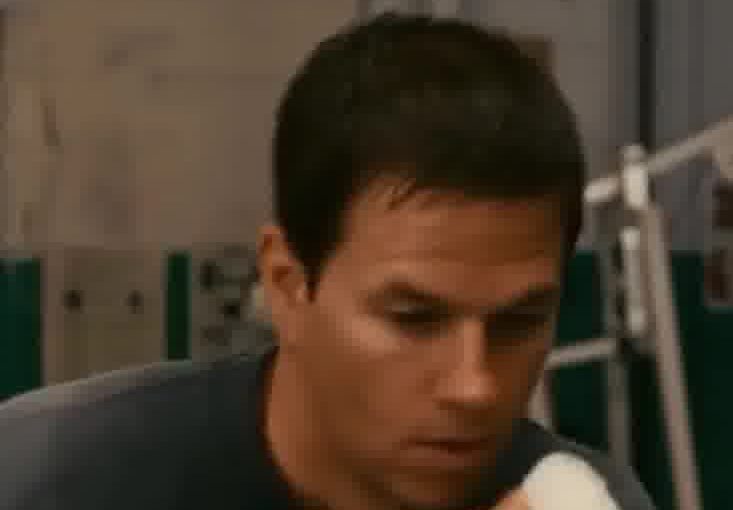

In [38]:
test_file =  "MW2.png"
answer,_,_= predict(test_file)
#print (answer)
load_img(test_file)

[[4.0507638e-07 4.1952792e-01 1.1847327e-05 7.1591991e-08 5.7998520e-01
  4.6416183e-04 3.4513170e-07 1.0047881e-05]]
Mark Wahlberg 0.5799852 Colin Farrell


In [34]:
!pwd

/media/hdd1/dataset/celebrityfaces
